# Instabil periodikus pályák keresése Astrojax ingában

A módszer alapja megtalálható itt: https://arxiv.org/abs/1405.5347. A script először a dinamikai rendszert leíró egyenleteket származtatja, nevezetesen:

- Tömegmátrix és potenciál kiszámítása szimbolikusan (`SymPy` csomag),
- Hamilton-függvény numerikus közelítése (szimbolikusan is lehetne, de az lassú),
- Kanonikus pozíciók és momemtumok számítása.

A perodikus pályák kereséséhez

- A numerikus integrálást adott kezdőpontból indítva a periódusidő kétszereséig futtatjuk, rendszeres időközönként mintát véve,
- Négyzetes hibát számolunk az első és a második periódushoz tartozó megfelelő minták között,
- A hibaösszeget Levenberg–Marquardt helyett L-BFGS algoritmussal minimalizáljuk, ahol a grandienseket automatikus differenciálással származtatjuk.

In [1]:
using Plots
using DifferentialEquations, Optim, Zygote, DiffEqSensitivity
using SymPy

## Paraméterek, dinamikai változók és az Astrojax inga

In [2]:
m12,L,A,ω,g = 1.,1.,0.2,10.,9.81 # tömegarány, kötélhossz, amplitúdó, frekvencia, gravitáció
t  = Sym("t")
q  = [f(t) for f in @symfuns θ1 θ2 l]
qd = [f.diff(t) for f in q]
D  = length(q);

θ1,θ2,l    = q
θ1d,θ2d,ld = qd

# Astrojax inga
x1,y1 = l*sin(θ1),A*cos(ω*t)-l*cos(θ1)
x2,y2 = x1+(L-l)*sin(θ2),y1-(L-l)*cos(θ2)

x1d,y1d = x1.diff(t),y1.diff(t)
x2d,y2d = x2.diff(t),y2.diff(t);

## Tömegmátrix és potenciál kiszámítása

In [3]:
function mat(v)
    v  = v.expand()
    M  = sympy.zeros(D,D)
    for i in 1:D
        M[i,i] = v.coeff(qd[i]^2).simplify()
        for j in i+1:D
            M[i,j] = v.coeff(qd[i]*qd[j]).simplify()/2
            M[j,i] = M[i,j]
        end
    end
    return M
end

mass = m12*mat(x1d^2+y1d^2) + mat(x2d^2+y2d^2)
pot  = m12*g*y1 + g*y2;

## Hamilton-függvény

In [4]:
# SymPy-Julia konverzió (ronda hack)
M_ = mass.subs(zip(q,["q$i" for i in 1:D]))
V_ = pot.subs(zip(q,["q$i" for i in 1:D]))
eval(Meta.parse("M(q,t) = " * reduce(replace,[r"q(\d+)"=>s"q[\1]","Sym"=>""],init=string(M_))))
eval(Meta.parse("V(q,t) = " * reduce(replace,[r"q(\d+)"=>s"q[\1]","Sym"=>""],init=string(V_))));

H(q,p,t) = 0.5*sum(p.*(M(q,t)\p)) + V(q,t);

## Numerikus integrálás

In [5]:
function F!(du,u,par,t)
    T   = par[1]
    q,p = u[1:D],u[(D+1):(2*D)]
    dp  = -Zygote.gradient(q->H(q,p,t),q)[1]
    dq  = Zygote.gradient(p->H(q,p,t),p)[1]
    du[1:D] .= dq[1:D].*T
    du[(D+1):(2*D)] .= dp[1:D].*T
end

function predict(u)
    dt = 1/N
    prob = ODEProblem(F!,u,(0.,2.),[T])
    return concrete_solve(prob,Vern9(),u,[T],saveat=dt)
end;

## Veszteségfüggvény

In [6]:
function loss(u)
    sol   = predict(u)
    sol[1:2,:] .%= (2*pi)
    return sum((sol[:,1:N] .- sol[:,(N+1):(2*N)]).^2)
end

function dloss!(s,u)
    s .= reshape(Zygote.forward_jacobian(loss,u)[2],:)
end;

## "Közeli" periodikus pálya keresése, fázisdiagramok

In [7]:
N,T = 10000,2*pi/ω # mintapontok és periódushossz
u0  = [pi/4,pi/3,0.5,0.,1.3,0.] # kezdőállapot
res = optimize(loss,dloss!,u0,LBFGS())

opt  = res.minimizer
prob = ODEProblem(F!,opt,(0.,T),[1.])
sol  = DifferentialEquations.solve(prob,Vern9(),saveat=0.01);

┌ Info: Saved animation to 
│   fn = /home/bj0rn/Desktop/IYPT/astro_2pi.gif
└ @ Plots /home/bj0rn/.julia/packages/Plots/rNwM4/src/animation.jl:98


Plots.AnimatedGif("/home/bj0rn/Desktop/IYPT/astro_2pi.gif")
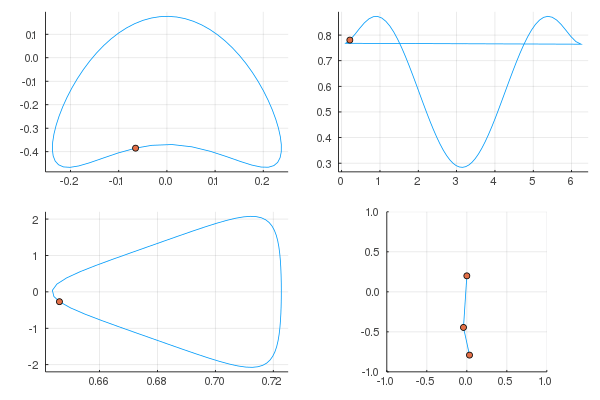

In [8]:
anim = @animate for i in 1:length(sol)
    θ1_,θ2_,l_ = sol.u[i][1:3]
    
    y0_     = A*cos(ω*sol.t[i])
    x1_,y1_ = l_*sin(θ1_),y0_-l_*cos(θ1_)
    x2_,y2_ = x1_+(L-l_)*sin(θ2_),y1_-(L-l_)*cos(θ2_)
    
    plots = []
    for j in 1:D
        p = plot(sol[j,:].%(2*pi),sol[j+D,:].%(2*pi),legend=:none)
        p = scatter!([sol[j,i]%(2*pi)],[sol[j+D,i]%(2*pi)])
        push!(plots,p)
    end
    
    p = plot([0,x1_,x2_],[y0_,y1_,y2_],xlims=(-1,1),ylims=(-1,1),aspect_ratio=:equal,legend=:none)
    p = scatter!([0,x1_,x2_],[y0_,y1_,y2_])
    push!(plots,p)
    plot(plots...)
    end every 3
gif(anim,"astro_2pi.gif",fps=40)

In [9]:
N,T = 10000,4*pi/ω
u0  = [pi/4,pi/3,0.5,0.,1.2,0.]
res = optimize(loss,dloss!,u0,LBFGS())

opt  = res.minimizer
prob = ODEProblem(F!,opt,(0.,T),[1.])
sol  = DifferentialEquations.solve(prob,Vern9(),saveat=0.01);

┌ Info: Saved animation to 
│   fn = /home/bj0rn/Desktop/IYPT/astro_4pi.gif
└ @ Plots /home/bj0rn/.julia/packages/Plots/rNwM4/src/animation.jl:98


Plots.AnimatedGif("/home/bj0rn/Desktop/IYPT/astro_4pi.gif")
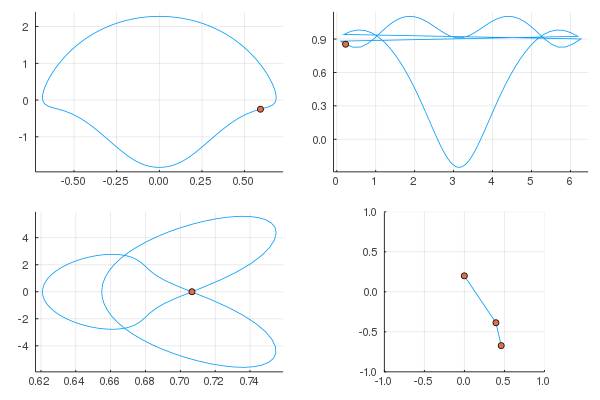

In [10]:
anim = @animate for i in 1:length(sol)
    θ1_,θ2_,l_ = sol.u[i][1:3]
    
    y0_     = A*cos(ω*sol.t[i])
    x1_,y1_ = l_*sin(θ1_),y0_-l_*cos(θ1_)
    x2_,y2_ = x1_+(L-l_)*sin(θ2_),y1_-(L-l_)*cos(θ2_)
    
    
    plots = []
    for j in 1:D
        p = plot(sol[j,:].%(2*pi),sol[j+D,:].%(2*pi),legend=:none)
        p = scatter!([sol[j,i]%(2*pi)],[sol[j+D,i]%(2*pi)])
        push!(plots,p)
    end
    
    p = plot([0,x1_,x2_],[y0_,y1_,y2_],xlims=(-1,1),ylims=(-1,1),aspect_ratio=:equal,legend=:none)
    p = scatter!([0,x1_,x2_],[y0_,y1_,y2_])
    push!(plots,p)
    plot(plots...)
    end every 3
gif(anim,"astro_4pi.gif",fps=40)